# **Multivariate Conditional Time-series Generative Adversarial Networks (MC-TimeGAN)**

Implemented in PyTorch `2.2.0+cu121` (GPU) and`2.3.1+cpu` (CPU)


##### **A.[Importing Libraries](#importing-libraries)** 
##### **B. [Functions](#functions)**
##### **C. [Data Loading, Preparation, and Visualization](#data-loading-preparation-and-visualization)**
##### **D. [MCTimeGAN: A Conditional Time Series Generative Adversarial Network](#mctimegan-a-conditional-time-series-generative-adversarial-network)**
This class implements a conditional GAN for generating synthetic time series data. It includes the following components:
The class also includes methods for transforming new data using the trained generator and for reporting training losses.
##### **E. [Train the MC-TimeGan model](#train-the-model)**
This block provides a step-by-step guide to training and evaluating the MC-TimeGAN model, including data preparation, model initialization, training, and visualization of the results.

If PV data is to be generated set 'flag_sgen' true otherwise false for load data

In [1]:
flag_sgen = True # false for load

### **A. Importing Libraries** <a id="importing-libraries"></a>

The following code imports various libraries required for data handling, preprocessing, model building, and evaluation. The libraries are categorized into their specific tasks such as operating system interaction, data manipulation, neural network implementation, and visualization.

In [2]:
# Standard library imports
import os  # For interacting with the operating system
import time  # For tracking time
import datetime  # For handling date and time

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
from sklearn.utils import shuffle  # For shuffling datasets

# Import the custom metrics functions
from helper.metrics import visualization
from helper.data_processing import save_model, loading, preparing
from helper.mctimegan import MCTimeGAN

#### **Device Selection**
If a CUDA-capable GPU is available, it selects 'cuda'. If MPS is available (for Apple hardware), it selects 'mps'. If neither CUDA nor MPS is available, it defaults to 'cpu'.

In [3]:
# Determine the available device for computation: CUDA, MPS, or CPU
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
# Output the selected device
print(f'Using {device} device')
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
# Check pandas version
print(f"pandas version: {pd.__version__}")

Using cuda device
PyTorch version: 2.2.0+cu121
pandas version: 2.2.0


### **B. Functions** <a id="functions"></a>

This section defines functions for saving the model, loading data, preparing data with scaling and sliding window, and setting seeds for reproducibility. 
- **`save_model(model: nn.Module(), data: dict(), name: str() = None) -> None`**: Saves the model state and training metadata to files.
- **`loading(*files: str()) -> pd.DataFrame`**: Loads CSV files into pandas DataFrames.
- **`preparing(*inputs: tuple(), horizon: int(), shuffle_stack: bool() = True, random_state: int() = None) -> np.ndarray`**: Prepares data by scaling and creating sequences with a sliding window.
- **`seed_worker(worker_id)`**: Sets seeds for reproducibility in PyTorch.

The following code sets a random seed for PyTorch to ensure reproducibility of results. By initializing a `torch.Generator` and setting a manual random seed, we can control the randomness in PyTorch operations.

In [4]:
# Set random seed for PyTorch
g = torch.Generator()
g.manual_seed(0)

### **C. Data Loading, Preparation, and Visualization** <a id="data-loading-preparation-and-visualization"></a>

The following code accomplishes the following tasks:

1. **Loading Data**: Uses the `loading` function to load data from the specified CSV files (`feeder_loads_4w_data` and `feeder_loads_4w_labels_ordinal`).
2. **Optional Column Selection**: Allows for specific columns from the data and labels to be selected by uncommenting the relevant lines.
3. **Autocorrelation Plots**: Generates two subplots to display the autocorrelation of the data. The second subplot's x-axis is limited to 150 for focused analysis.
4. **Data Preparation and Shuffling**: Prepares and shuffles the data for training, ensuring the dataset is similar to independent and identically distributed (iid), which is crucial for the TimeGAN model.
   - Defines the horizon (sequence length).
   - Scales the data and creates sequences using a sliding window of the defined horizon.
   - Shuffles the prepared data and labels.
   - Prints the shapes of the training data and labels.
   - Saves copies of the training data and labels for later recovery during evaluation.
   - Extracts the number of input features and conditions.
5. **Visualizations**: Compares the original data and labels with their scaled versions to understand the impact of scaling.


    ___  ________     _____ _                _____   ___   _   _ 
    |  \/  /  __ \   |_   _(_)              |  __ \ / _ \ | \ | |
    | .  . | /  \/_____| |  _ _ __ ___   ___| |  \// /_\ \|  \| |
    | |\/| | |  |______| | | | '_ ` _ \ / _ \ | __ |  _  || . ` |
    | |  | | \__/\     | | | | | | | | |  __/ |_\ \| | | || |\  |
    \_|  |_/\____/     \_/ |_|_| |_| |_|\___|\____/\_| |_/\_| \_/
Shape of "helper/data/raw/feeder_sgens_4w_data.csv": (2688, 2)
Shape of "helper/data/raw_labels/feeder_sgens_4w_labels_ordinal.csv": (2688, 2)
max_val:
 [0.05675174 0.19568925] 
min_val:
 [0. 0.]

data_train shape: (2592, 96, 2) 
labels_train shape: (2592, 96, 2)


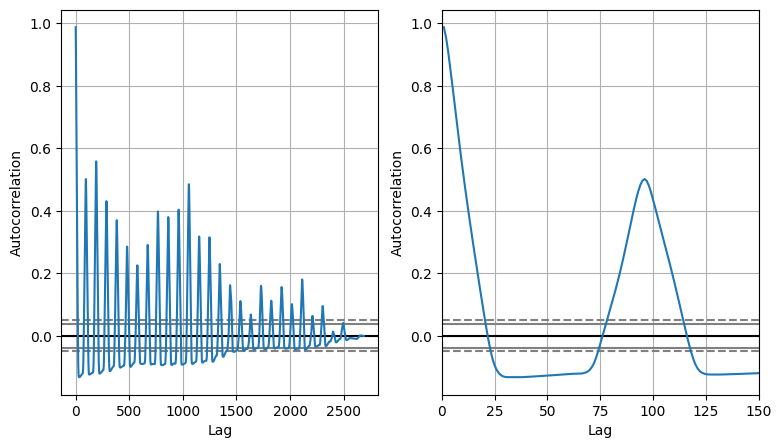

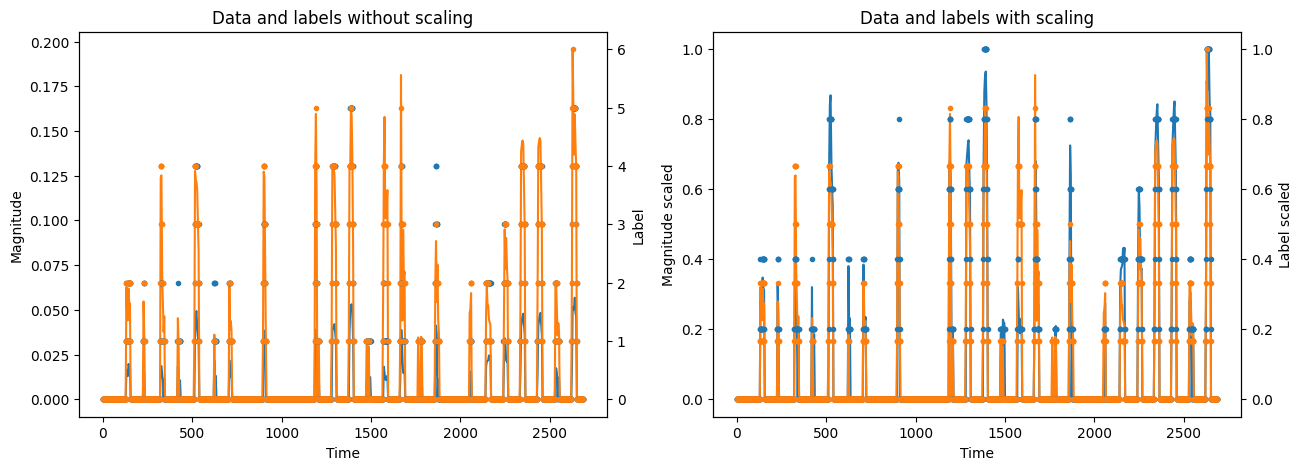

In [5]:
if flag_sgen:
    # 1. Load Data
    # Specify the filenames for the sgens data and labels
    data_file = 'feeder_sgens_4w_data.csv'
    labels_file = 'feeder_sgens_4w_labels_ordinal.csv'
else:
    # 1. Load Data
    # Specify the filenames for the load data and labels
    data_file = 'feeder_loads_4w_data.csv'
    labels_file = 'feeder_loads_4w_labels_ordinal.csv' 

# Construct the full paths to the data and label files
load_data_path = os.path.join('helper','data','raw', data_file)
load_labels_path = os.path.join('helper','data','raw_labels',labels_file)

# Load the data and labels using the loading function
data, labels = loading(load_data_path, load_labels_path)
# 2. Optional: Select specific columns
# data = data.iloc[:, [1]]
# labels = labels.iloc[:, [1]]

# 3. Generate autocorrelation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ax1.sharey(ax2)
pd.plotting.autocorrelation_plot(data, ax=ax1)
pd.plotting.autocorrelation_plot(data, ax=ax2)
ax2.set_xlim((0, 150))

# 4. Data preparation and shuffling
HORIZON = 96
data_train, max_val, min_val, labels_train = preparing((data, True), (labels, False), horizon=HORIZON, shuffle_stack=False)
data_train, labels_train = shuffle(data_train, labels_train)

# Output data shapes and save copies for later recovery
print('max_val:\n', max_val, '\nmin_val:\n', min_val)
print('\ndata_train shape:', data_train.shape, '\nlabels_train shape:', labels_train.shape)

data_train_recover = data_train.copy()
labels_train_recover = labels_train.copy()
data_recover = data.copy()
labels_recover = labels.copy()

# Extract input dimensions
input_features = data_train.shape[-1]
input_conditions = labels_train.shape[-1]

# 5. Visualizations: Compare original and scaled data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot data and labels without scaling
ax1_label = ax1.twinx()
ax1.plot(data)
ax1_label.plot(labels, '.')
ax1.set_title('Data and labels without scaling')
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')
ax1_label.set_ylabel('Label')

# Plot data and labels with scaling
ax2_label = ax2.twinx()
ax2.plot((data - min_val) / (max_val - min_val))
ax2_label.plot((labels - labels.min()) / labels.max(), '.')
ax2.set_title('Data and labels with scaling')
ax2.set_xlabel('Time')
ax2.set_ylabel('Magnitude scaled')
ax2_label.set_ylabel('Label scaled')

plt.show()

### **D. MCTimeGAN: A Conditional Multivariate Time Series Generative Adversarial Network** <a id="mctimegan-a-conditional-time-series-generative-adversarial-network"></a>

This class implements a conditional GAN for generating synthetic time series data. It includes the following MC-TimeGAN model components:
<ul>
  <li><strong>Conditioning Network</strong>: The Conditioning Network transforms input conditions using a linear layer and a Tanh activation, followed by another linear layer.</li>
  <li><strong>Embedding Network</strong>: The Embedder uses an RNN (GRU or LSTM) to process input sequences. It consists of the RNN followed by a linear layer with a Sigmoid activation.Transforms the input time series data into a latent space.</li>
  <li><strong>Recovery Network</strong>: The Recovery network reconstructs the original input features from the hidden states using an RNN and a linear layer with a Sigmoid activation. Recovers the original data from the latent space representation.</li>
  <li><strong>Generator Network</strong>: The Generator generates synthetic sequences from random noise using an RNN and a linear layer with a Sigmoid activation. Generates synthetic data from random noise.</li>
  <li><strong>Supervisor Network</strong>: The Supervisor network is a simplified RNN (GRU or LSTM) that aids the generator in producing more realistic sequences. It uses one fewer layer than the generator. Supervises the generator during training to ensure temporal consistency.</li>
  <li><strong>Discriminator Network</strong>: The Discriminator evaluates the authenticity of sequences using a bidirectional RNN and a linear layer. The output is a single value indicating the realness of the sequence. Distinguishes between real and generated data.</li>
  <li><strong>Loss Functions</strong>: Defines loss functions for the GAN components, including discriminator** loss, generator loss, and embedder loss.</li>
</ul>

The training process consists of three phases:
<ol>
  <li><strong>Embedding Network Training</strong>: Trains the embedding and recovery networks.</li>
  <li><strong>Supervised Generator Training</strong>: Trains the generator with supervised loss.</li>
  <li><strong>Joint Training</strong>: Alternates between training the generator and discriminator.</li>
</ol>

The class also includes methods for transforming new data using the trained generator and for reporting training losses.

<figure style="text-align: left;">
  <img src="helper/img/mc_timegan.png" alt="MCTimeGAN Structure" width="11%">
</figure>

Structure of our MC-TimeGAN implementation used in the synthetic grid congestion framework.
The architecture includes Conditioning Network (C), Embedder (E), Recovery (R), Supervisor (S), Generator (G), and Discriminator (D). 
Dashed lines indicate the concatenation of the representation vectors of the labels $\mathbf{w}_t$ with the input sequences for conditional network processing.
The script **[mctimegan.py](helper/mctimegan.py)** defines various neural network components for an MC-TimeGAN implementation using PyTorch 2. Each class and function is detailed below

### **E. Train the MC-TimeGan model** <a id="train-the-model"></a>

This notebook provides a step-by-step guide to training and evaluating the MC-TimeGAN model, including data preparation, model initialization, training, and visualization of the results.

**Key Sections:**

1. **Define Hyperparameters and Initialize, Configure the Model**: Set up parameters like hidden dimensions, epochs, batch size, and learning rate for the model. Initialize the MCTimeGAN model with the specified parameters and move it to the appropriate device (CPU or GPU).
2. **Timing the Training Process**: Measure the time taken to train the model.
3. **Load and Configure the Model**: Load a pre-trained model and move it to the appropriate device.
4. **Record Training Metadata**: Record and optionally save metadata about the training process.
5. **Recover and Shuffle Labels**: Recover and shuffle the training data and labels, and generate new data using the model.
6. **Stack and Rescale Generated Data**: Stack and rescale the generated data to match the original data scale.
7. **Plot Results**: Compare the generated data with the real training data using plots.
8. **Visualize Generated Data**: Use PCA (Principal Component Analysis) and t-SNE (t-Distributed Stochastic Neighbor Embedding) techniques to visualize the generated data.
   - **PCA**: A technique that reduces the dimensionality of the data while preserving as much variance as possible. It helps in visualizing high-dimensional data in 2D or 3D space.
   - **t-SNE**: A technique that visualizes high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is particularly effective for high-dimensional data where clusters may not be linearly separable.
9. **Evaluate Predictive and Discriminative Scores**: Calculate and display predictive and discriminative score metrics for the training and generated data.
10. **Generate New Data and Plot Results**: Generate new data with reshaped conditions and plot it alongside the real data.
11. **Export Generated Data to CSV**: Export the generated data to a CSV file.
12. **Generate and Plot Data with Different Labels**: Load different data and labels, generate new data, and plot it alongside the real data.
13. **Plot Autocorrelation of Original and Generated Data**: Create autocorrelation plots for both the original and generated data.
14. **Autocorrelation Plots by Features**: Generate autocorrelation plots for each feature in the data.
15. **Prepare Data and Visualize**: Process the original and synthetic data, and visualize it using PCA and t-SNE.
16. **Evaluate Predictive and Discriminative Scores**: data_original, data_synthetic.
17. **Plot Training Losses**: Retrieve and plot training losses if available.
18. **Exporting Synthetic Data to CSV**: Export the synthetic data to a CSV file.
19. **Conclusion**: Summarize the tutorial and provide closing remarks.


**PCA (Principal Component Analysis):** PCA is a dimensionality reduction technique that transforms the data into a set of linearly uncorrelated components, ordered by the amount of variance they explain. It is useful for visualizing high-dimensional data in two or three dimensions.

**t-SNE (t-Distributed Stochastic Neighbor Embedding):** t-SNE is a nonlinear dimensionality reduction technique that is particularly well-suited for embedding high-dimensional data into a low-dimensional space (typically two or three dimensions) in a way that preserves the structure of the data. It is widely used for visualizing clusters and patterns in complex datasets.

Each section is designed to be executed in separate cells for better organization and clarity. Follow the instructions and comments in each section to understand and perform the necessary steps.

##### Section 1: Define Hyperparameters and Initialize, Configure the Model

In [6]:
# Number of hidden dimensions in the model
HIDDEN_DIM = 24

# Number of epochs for training
EPOCHS = 2000

# Size of each batch during training
BATCH_SIZE = 128

# Learning rate for the optimizer
LEARNING_RATE = 1e-3

# Flag to save stats and model
SAVE_STATS_AND_MODEL = False
# Seed for reproducibility (commented out)
torch.manual_seed(0)

# Initialize the MCTimeGAN model with specified parameters
mymodel = MCTimeGAN(input_features=input_features,
                    input_conditions=input_conditions,
                    hidden_dim=HIDDEN_DIM,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    learning_rate=LEARNING_RATE).to(device)

##### Section 2: Timing the Training Process

In [7]:
# Record the start time of the training process
start_time = time.time()

# Fit the model on training data (commented out)
# mymodel.fit(data_train, cond=labels_train)

# Record the end time of the training process
end_time = time.time()

##### Section 3: Load and Configure the Model

In [8]:
# Define the path to your model
if flag_sgen:
    model_path = 'helper/models/mc_timegan_sgen.pth'
else:
    model_path = 'helper/models/mc_timegan_load.pth'
# Check if CUDA is available and set the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the MCTimeGAN model with specified parameters
mymodel = MCTimeGAN(input_features=input_features,
                    input_conditions=input_conditions,
                    hidden_dim=HIDDEN_DIM,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    learning_rate=LEARNING_RATE).to(device)
# Load the model to the specified device
mymodel.load_state_dict(torch.load(model_path, map_location=device), strict=False)
# mymodel.load_state_dict(torch.load(model_path, map_location=device))
# Move the model to the appropriate device
mymodel.to(device)

MCTimeGAN(
  (condnet): ConditioningNetwork(
    (condition): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=1, bias=True)
    )
  )
  (embedder): Embedder(
    (rnn): GRU(3, 24, num_layers=3, batch_first=True)
    (model): Sequential(
      (0): Linear(in_features=24, out_features=24, bias=True)
      (1): Sigmoid()
    )
  )
  (recovery): Recovery(
    (rnn): GRU(25, 25, num_layers=3, batch_first=True)
    (model): Sequential(
      (0): Linear(in_features=25, out_features=2, bias=True)
      (1): Sigmoid()
    )
  )
  (generator): Generator(
    (rnn): GRU(3, 24, num_layers=3, batch_first=True)
    (model): Sequential(
      (0): Linear(in_features=24, out_features=24, bias=True)
      (1): Sigmoid()
    )
  )
  (supervisor): Supervisor(
    (rnn): GRU(25, 24, num_layers=2, batch_first=True)
    (model): Sequential(
      (0): Linear(in_features=24, out_features=24, bias=True)
      (1): Sigmoid

##### Section 4: Record Training Metadata

In [9]:
training_metadata = {
    'date': str(datetime.datetime.now()).rsplit('.')[0],
    'data': data_file + '.csv',
    'data_shape': data.shape,
    'fitting_time': np.round(end_time - start_time, 3),
    'labels': labels_file + '.csv',
    'labels_shape': labels.shape,
    'horizon': HORIZON,
    'hidden_dim': HIDDEN_DIM,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE
}

# Save the model if the flag is set
if SAVE_STATS_AND_MODEL:
    save_model(mymodel, training_metadata)

##### Section 5: Recover and Shuffle Labels

In [10]:
# Recover labels and shuffle the training data
data_train, labels_train = shuffle(data_train_recover, labels_train_recover)

# Generate data using the model
generated_data = mymodel.transform(data_train.shape, cond=labels_train)

##### Section 6: Stack and Rescale Generated Data

In [11]:
# Stack generated data into a numpy array
data_gen = np.stack(generated_data)

# Rescale generated data
data_gen = data_gen * max_val
data_gen = data_gen + min_val

# Rescale training data (Training data is scaled, therefore we need to rescale it as well!)
data_train = data_train * max_val
data_train = data_train + min_val

##### Section 7: Plot Results

Text(0, 0.5, 'Label')

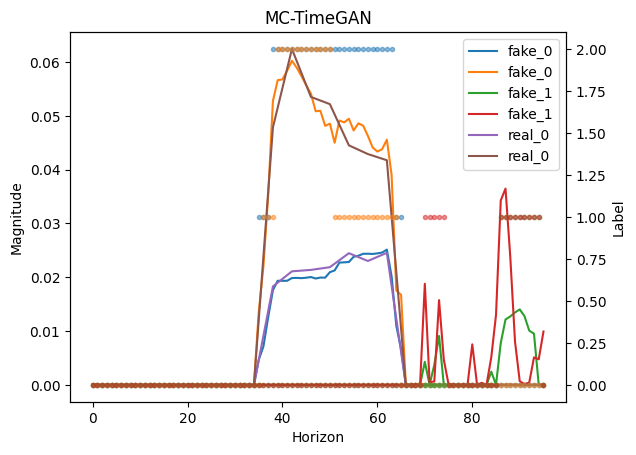

In [12]:
fig, ax = plt.subplots()
ax_label = ax.twinx()

# Plot generated data
for i in range(2):
    ax.plot(data_gen[i,:,:], label='fake_' + str(i))

# Plot real training data
ax.plot(data_train[0,:,:], label='real_0')

ax.legend()
ax.set_title('MC-TimeGAN')
ax.set_xlabel('Horizon')
ax.set_ylabel('Magnitude')

# Plot labels
for i in range(2):
    ax_label.plot(labels_train[i,:,:], '.', alpha=0.5)

ax_label.set_ylabel('Label')

##### Section 8: Visualize Generated Data

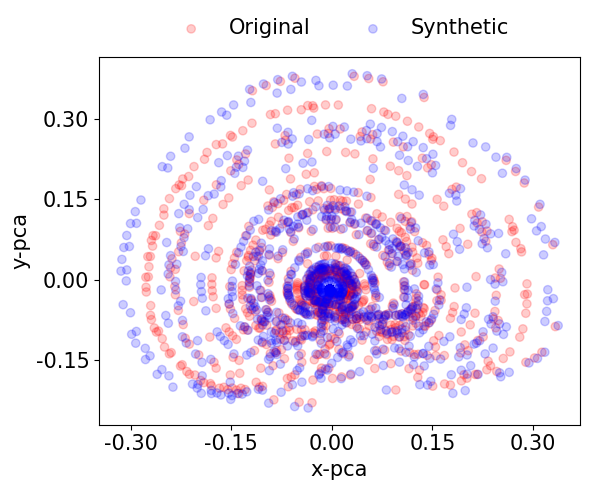

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.780880
[t-SNE] KL divergence after 300 iterations: 0.818723


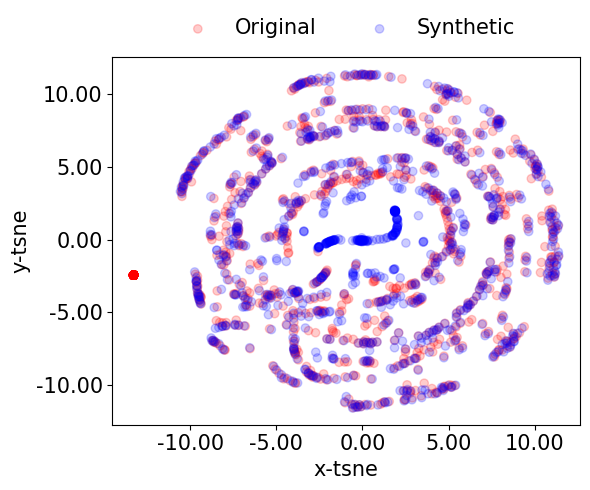

In [13]:
# Perform PCA visualization of the training and generated data
visualization(data_train, data_gen, 'pca')

# Save the PCA visualization plot (commented out)
# plt.savefig('figures/cTimeGAN_sgen_pca.pdf', bbox_inches='tight')

# Perform t-SNE visualization of the training and generated data
visualization(data_train, data_gen, 'tsne')

# Save the t-SNE visualization plot (commented out)
# plt.savefig('figures/cTimeGAN_sgen_tsne.pdf', bbox_inches='tight')

##### Section 9: Evaluate Predictive and Discriminative Scores
- data_train, data_gen (Section 10)
- data_original, data_synthetic (Section 17)

In [14]:
# Calculate and display predictive score metrics for the training and generated data
# predictive_score_metrics(data_train, data_gen)

# Calculate and display discriminative score metrics for the training and generated data
# discriminative_score_metrics(data_train, data_gen)

##### Section 10: Generate New Data and Plot Results

(1, 2688, 2)


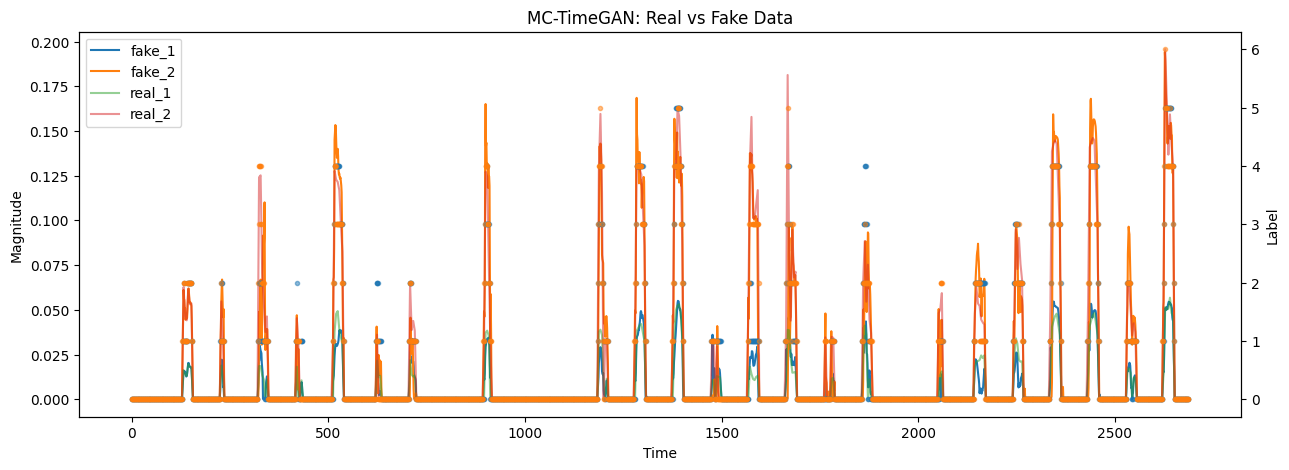

In [15]:
# Generate new data using the model with reshaped conditions
generated_data = mymodel.transform((1, data.shape[0], data_train.shape[-1]), cond=labels.to_numpy().reshape(1, labels.shape[0], labels_train.shape[-1]))

# Stack the generated data into a numpy array
data_gen = np.stack(generated_data)

# Rescale the generated data
data_gen = data_gen * max_val
data_gen = data_gen + min_val

# Print the shape of the generated data
print(data_gen.shape)

# Convert the generated data to a pandas DataFrame
data_export = pd.DataFrame(np.squeeze(data_gen), columns=['fake_' + str(i+1) for i in range(data_gen.shape[-1])])

# Apply thresholding to the generated data
if flag_sgen:
    data_export = data_export.mask(data_export < 15*1e-6, 0)

# Plot real vs fake data
fig, ax = plt.subplots(figsize=(15, 5))
ax_label = ax.twinx()

# Plot fake data
for i in range(data_export.shape[1]):
    ax.plot(data_export.iloc[:, i], label='fake_' + str(i+1))

# Plot real data
for i in range(data.shape[1]):
    ax.plot(data.iloc[:, i], label='real_' + str(i+1), alpha=0.5)

ax.legend()
ax.set_title('MC-TimeGAN: Real vs Fake Data')
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')

# Plot labels
ax_label.plot(labels.to_numpy(), '.', alpha=0.5)
ax_label.set_ylabel('Label')
plt.show()

##### Section 11: Export Generated Data to CSV

In [16]:
if flag_sgen:
    # Define the path and filename for the CSV export
    csv_filename = 'helper/synthetic_data/' + str(datetime.date.today()) + '_mc_timegan_feeder_sgens.csv'
else:
    # Define the path and filename for the CSV export
    csv_filename = 'helper/synthetic_data/' + str(datetime.date.today()) + '_mc_timegan_feeder_loads.csv'
# Export the DataFrame to a CSV file
data_export.to_csv(csv_filename, index=False)

##### Section 12: Generate and Plot Data with Different Labels


    ___  ________     _____ _                _____   ___   _   _ 
    |  \/  /  __ \   |_   _(_)              |  __ \ / _ \ | \ | |
    | .  . | /  \/_____| |  _ _ __ ___   ___| |  \// /_\ \|  \| |
    | |\/| | |  |______| | | | '_ ` _ \ / _ \ | __ |  _  || . ` |
    | |  | | \__/\     | | | | | | | | |  __/ |_\ \| | | || |\  |
    \_|  |_/\____/     \_/ |_|_| |_| |_|\___|\____/\_| |_/\_| \_/
Shape of "helper/data/raw/feeder_sgens_4w_data.csv": (2688, 2)

    ___  ________     _____ _                _____   ___   _   _ 
    |  \/  /  __ \   |_   _(_)              |  __ \ / _ \ | \ | |
    | .  . | /  \/_____| |  _ _ __ ___   ___| |  \// /_\ \|  \| |
    | |\/| | |  |______| | | | '_ ` _ \ / _ \ | __ |  _  || . ` |
    | |  | | \__/\     | | | | | | | | |  __/ |_\ \| | | || |\  |
    \_|  |_/\____/     \_/ |_|_| |_| |_|\___|\____/\_| |_/\_| \_/
Shape of "helper/data/modify_labels/feeder_sgens_4w_labels_ordinal_n5t1p15_n1.csv": (2688, 2)
(1, 2688, 2)


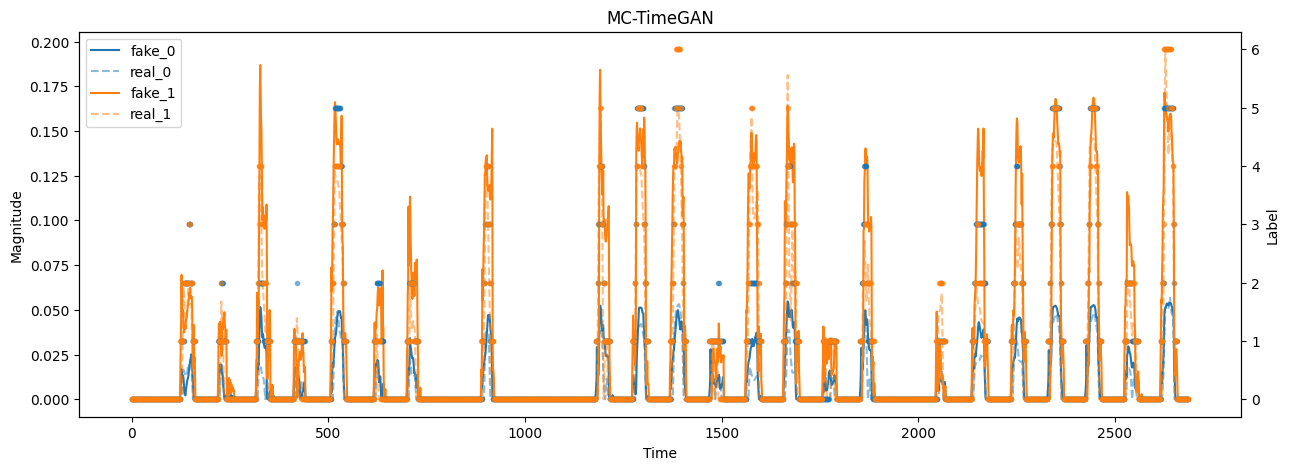

In [17]:
if flag_sgen:
    # Load other data and labels filenames using load function
    other_data = loading(os.path.join('helper', 'data', 'raw', 'feeder_sgens_4w_data.csv') ) 
    other_labels = loading(os.path.join('helper', 'data', 'modify_labels', 'feeder_sgens_4w_labels_ordinal_n5t1p15_n1.csv')) 
else:
    # Load other data and labels filenames using load function
    other_data = loading(os.path.join('helper', 'data', 'raw', 'feeder_loads_4w_data.csv') ) # 'feeder_sgens_filtered_4w_data.csv'
    other_labels = loading(os.path.join('helper', 'data', 'modify_labels', 'feeder_loads_4w_labels_ordinal_n5t1p25_n2.csv')) # 'feeder_sgens_filtered_4w_labels_ordinal_n5t1p15_n1.csv'


# Prepare other data for scaling
_, other_max_val, other_min_val = preparing((other_data, True), horizon=HORIZON)

# Initialize data_gen
data_gen = None

# Generate new data based on the condition
if data_train.shape[-1] > 1:
    generated_data = mymodel.transform((1, data.shape[0], data_train.shape[-1]), cond=other_labels.to_numpy().reshape(1, labels.shape[0], labels_train.shape[-1]))
    data_gen = np.stack(generated_data)
    # Rescaling
    data_gen = data_gen * other_max_val
    data_gen = data_gen + other_min_val
else:
    other_labels = other_labels.to_numpy()[np.newaxis, :, :]
    other_labels = np.swapaxes(other_labels, 0, -1)
    print(other_labels.shape)
    generated_data = mymodel.transform((other_labels.shape[0], other_labels.shape[1], data_train.shape[-1]), cond=other_labels)
    data_gen = np.stack(generated_data)
    # Rescaling
    data_gen = data_gen * other_max_val[:, np.newaxis, np.newaxis]
    data_gen = data_gen + other_min_val[:, np.newaxis, np.newaxis]

# Print the shape of the generated data
print(data_gen.shape)

# Plot the generated and real data
fig, ax = plt.subplots(figsize=(15, 5))
colors = list(mcolors.TABLEAU_COLORS.keys())
ax_label = ax.twinx()

# Plot the generated data and real data with corresponding labels
for i in range(data_gen.shape[0]):
    for j in range(data_gen.shape[-1]):
        color = colors.pop(0)
        ax.plot(data_gen[i, :, j], color=color, label='fake_' + str(j))
        ax.plot(other_data.to_numpy()[:, j], color=color, label='real_' + str(j), ls='--', alpha=0.5)
        if len(other_labels.shape) < 3:
            ax_label.plot(other_labels.to_numpy()[:, j], '.', color=color, alpha=0.5)
        else:
            ax_label.plot(np.squeeze(other_labels.to_numpy())[:, j], '.', color=color, alpha=0.5)

# Add legend, title, and labels
ax.legend()
ax.set_title('MC-TimeGAN')
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax_label.set_ylabel('Label')

# Show the figure
plt.show()

##### Section 13: Plot Autocorrelation of Original and Generated Data

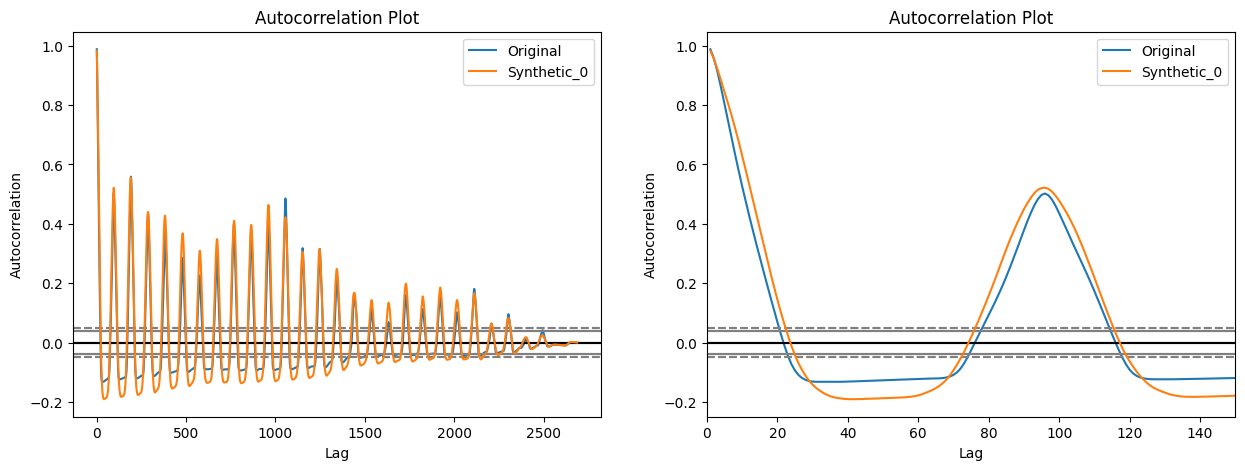

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot autocorrelation of original data on the first subplot
pd.plotting.autocorrelation_plot(data, ax=ax1, label='Original')

# Plot autocorrelation of generated data on the first subplot
for i in range(data_gen.shape[0]):
    pd.plotting.autocorrelation_plot(data_gen[i, :, :], ax=ax1, label='Synthetic_' + str(i))

# Plot autocorrelation of original data on the second subplot
pd.plotting.autocorrelation_plot(data, ax=ax2, label='Original')

# Plot autocorrelation of generated data on the second subplot
for i in range(data_gen.shape[0]):
    pd.plotting.autocorrelation_plot(data_gen[i, :, :], ax=ax2, label='Synthetic_' + str(i))

# Share y-axis between the two subplots
ax1.sharey(ax2)

# Set x-axis limit for the second subplot
ax2.set_xlim(0, 150)

# Set titles for the subplots
ax1.set_title('Autocorrelation Plot')
ax2.set_title('Autocorrelation Plot')

# Show the figure
plt.show()

##### Section 14: Autocorrelation Plots by Features

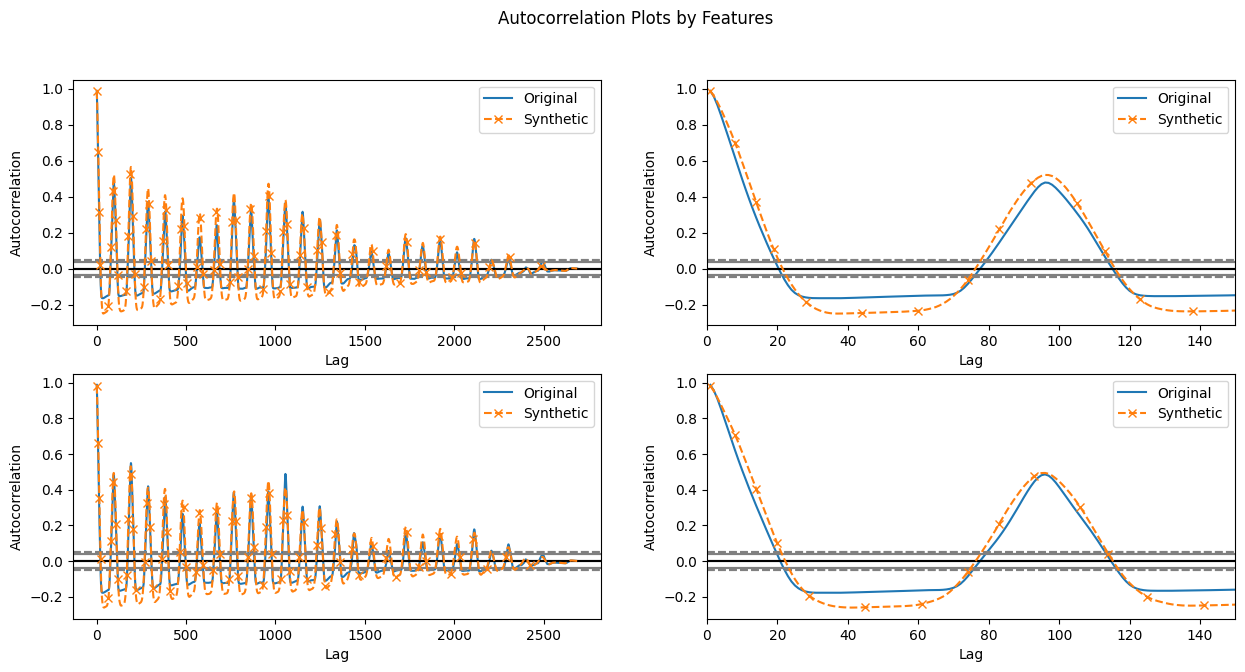

In [19]:
fig, ax = plt.subplots(data.shape[-1], 2, figsize=(15, 3.5*data.shape[-1]))

# Ensure ax is a 2D array even when there's only one feature
if data.shape[-1] < 2:
    ax = ax[np.newaxis, :]

fig.suptitle('Autocorrelation Plots by Features')

# Loop through each feature to create autocorrelation plots
for i in range(data.shape[-1]):
    # Share y-axis between the two subplots for each feature
    ax[i, 0].sharey(ax[i, 1])
    
    # Plot autocorrelation for the original data in the first column
    pd.plotting.autocorrelation_plot(data.iloc[:, [i]], ax=ax[i, 0], label='Original')
    
    # Plot autocorrelation for the generated data in the first column
    pd.plotting.autocorrelation_plot(pd.Series(data_gen[0, :, i]), ax=ax[i, 0], ls='--', marker='x', markevery=0.1, label='Synthetic')
    
    # Set x-axis limit for the second column
    ax[i, 1].set_xlim(0, 150)
    
    # Plot autocorrelation for the original data in the second column
    pd.plotting.autocorrelation_plot(data.iloc[:, [i]], ax=ax[i, 1], label='Original')
    
    # Plot autocorrelation for the generated data in the second column
    pd.plotting.autocorrelation_plot(pd.Series(data_gen[0, :, i]), ax=ax[i, 1], ls='--', marker='x', markevery=0.1, label='Synthetic')

# Show the figure
plt.show()

#####  Section 15: Prepare Data and Visualize
Process the original and synthetic data, and visualize it using PCA and t-SNE.

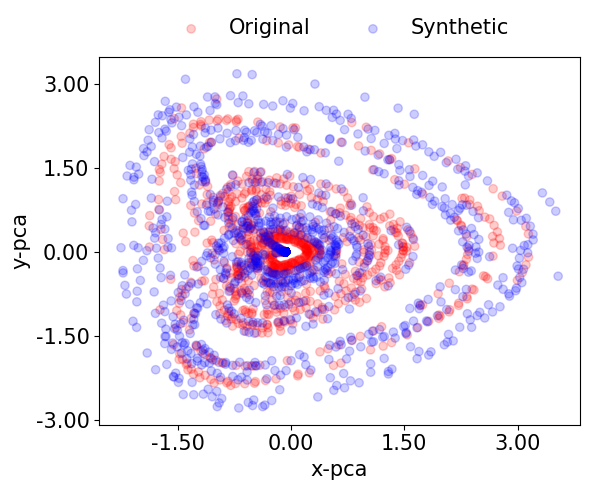

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.475140
[t-SNE] KL divergence after 300 iterations: 1.039359


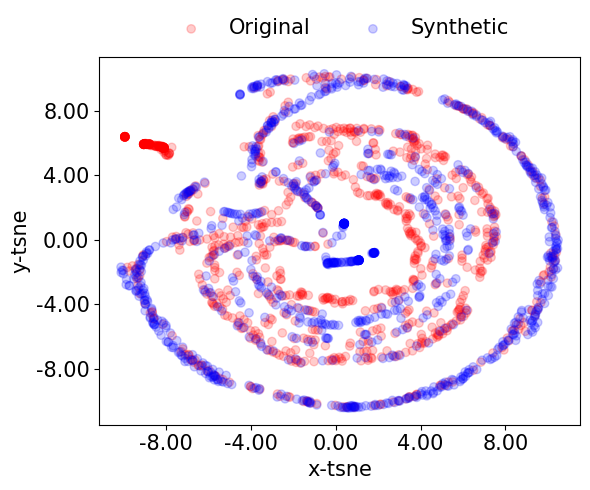

In [20]:
# Uncomment to prepare and modify labels for synthetic data generation (currently commented out)
# labels_mod = preparing((other_labels, False), horizon=HORIZON, shuffle_stack=True)[0]

# Uncomment to generate synthetic data based on modified labels (currently commented out)
# data_synthetic = np.stack(mymodel.transform(data_train.shape, cond=labels_mod))

# Prepare the original data for analysis
data_original, _, _ = preparing((data, True), horizon=HORIZON, shuffle_stack=True)

# Prepare the synthetic data for analysis
data_synthetic, _, _ = preparing((np.squeeze(data_gen), True), horizon=HORIZON, shuffle_stack=True)

visualization(data_original, data_synthetic, 'pca')
# plt.savefig('figures/cTimeGAN_load_mod_pca.pdf', bbox_inches='tight')
visualization(data_original, data_synthetic, 'tsne')
# plt.savefig('figures/cTimeGAN_load_mod_tsne.pdf', bbox_inches='tight')

##### Section 16: Evaluate Predictive and Discriminative Scores
- data_train, data_gen (Section 10)
- data_original, data_synthetic (Section 17)

In [21]:
# Evaluate predictive and discriminative scores using original and synthetic data
# predictive_score_metrics(data_original, data_synthetic)
# discriminative_score_metrics(data_original, data_synthetic)

In [22]:
# Prepare the DataFrame by squeezing the data and renaming the columns appropriately
data_synthetic = pd.DataFrame(np.squeeze(data_gen), columns=['fake_' + str(i+1) for i in range(data_gen.shape[-1])])
# Save the DataFrame to a CSV file with the current date in the filename
if flag_sgen:
    data_synthetic.to_csv('helper/synthetic_data/' + str(datetime.date.today()) + '_mc_timegan_feeder_sgens_n5t1p25_n3.csv', index=False)
else:
    data_synthetic.to_csv('helper/synthetic_data/' + str(datetime.date.today()) + '_mc_timegan_feeder_loads_n5t1p25_n3.csv', index=False)

##### Section 19: Conclusion

This concludes our tutorial on using MC-TimeGAN for synthetic grid congestion data generation. 

In [23]:
# List all installed packages and save to requirements.txt
!pip freeze > requirements.txt
# Read and print the contents of requirements.txt to verify
with open('requirements.txt', 'r') as file:
    print(file.read())

absl-py==2.1.0
aiohttp==3.9.5
aiosignal==1.3.1
ale-py==0.8.1
alembic==1.13.1
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-generator==1.10
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
AutoROM==0.4.2
AutoROM.accept-rom-license==0.6.1
Babel==2.15.0
bash_kernel==0.9.3
batchspawner @ git+https://github.com/jupyterhub/batchspawner.git@87874004b2dc761598405a564a26e5f6775bb473
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.7.0
blosc2==2.5.1
bokeh==3.4.1
box2d-py==2.3.5
build==1.0.3
cachetools==5.3.2
casadi==3.6.5
certifi==2024.2.2
certipy==0.1.3
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==1.6.0
colorlog==6.8.2
comm==0.2.1
contourpy==1.2.0
cryptography==42.0.7
cycler==0.12.1
dalex==1.7.0
dask==2024.5.0
dask-jobqueue==0.8.5
dask_labextension==7.0.0
dateparser==1.2.0
debugpy==1.8.1
decorator==4.4.2
deepdiff==6.7.1
defusedxml==0.7.1
dill==0.3.8
distlib==0.3.8
distributed==2024.5.0
dm-tree==0.1.8
e==